In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.3858 - acc: 0.1909
Epoch 00001: val_loss improved from inf to 12.25245, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_2_checkpoint/001-12.2525.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 12.3858 - acc: 0.1909 - val_loss: 12.2525 - val_acc: 0.2010
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.3848 - acc: 0.2674
Epoch 00002: val_loss improved from 12.25245 to 11.73878, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_2_checkpoint/002-11.7388.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 11.3850 - acc: 0.2674 - val_loss: 11.7388 - val_acc: 0.2416
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.9297 - acc: 0.2986
Epoch 00003: val_loss did not improve from 11.73878
36805/36805 [==

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.5613 - acc: 0.5826
Epoch 00028: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.5615 - acc: 0.5826 - val_loss: 11.0343 - val_acc: 0.2979
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.5720 - acc: 0.5819
Epoch 00029: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.5724 - acc: 0.5819 - val_loss: 10.6975 - val_acc: 0.3135
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.4439 - acc: 0.5901
Epoch 00030: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.4444 - acc: 0.5901 - val_loss: 10.9229 - val_acc: 0.3070
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3655 - acc: 0.5952
Epoch 00031: val_loss improved from 10.34619 to 10.27689, saving mode

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.2486 - acc: 0.6677
Epoch 00057: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.2484 - acc: 0.6677 - val_loss: 10.6323 - val_acc: 0.3245
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1859 - acc: 0.6718
Epoch 00058: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.1866 - acc: 0.6718 - val_loss: 10.5563 - val_acc: 0.3296
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1933 - acc: 0.6711
Epoch 00059: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.1944 - acc: 0.6710 - val_loss: 10.8801 - val_acc: 0.3103
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1721 - acc: 0.6733
Epoch 00060: val_loss did not improve from 10.25476
36805/36805 [====

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.6150 - acc: 0.7090
Epoch 00087: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.6148 - acc: 0.7090 - val_loss: 11.2760 - val_acc: 0.2879
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5722 - acc: 0.7114
Epoch 00088: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.5733 - acc: 0.7113 - val_loss: 10.5988 - val_acc: 0.3284
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5151 - acc: 0.7150
Epoch 00089: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.5158 - acc: 0.7150 - val_loss: 11.3477 - val_acc: 0.2856
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5145 - acc: 0.7157
Epoch 00090: val_loss did not improve from 10.25476
36805/36805 [====

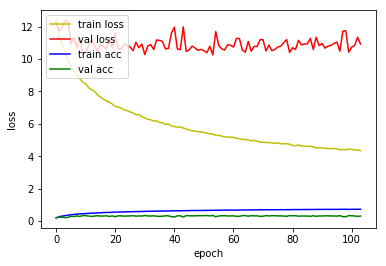

4815/4815 [==============================] - 3s 560us/sample - loss: 10.7863 - acc: 0.3113
Loss: 10.786306068681853 Accuracy: 0.31131878

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2479 - acc: 0.3354
Epoch 00001: val_loss improved from inf to 3.55951, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_2_checkpoint/001-3.5595.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 4.2484 - acc: 0.3354 - val_loss: 3.5595 - val_acc: 0.3413
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.6445
Epoch 00002: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.0629 - acc: 0.6445 - val_loss: 4.8194 - val_acc: 0.3289
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1986 - acc: 0.7860
Epoch 00003: val_loss did not improve from 3.55951
36805/36805 [================

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2891 - acc: 0.9709
Epoch 00030: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.2891 - acc: 0.9709 - val_loss: 8.1002 - val_acc: 0.3678
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3141 - acc: 0.9668
Epoch 00031: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.3145 - acc: 0.9668 - val_loss: 8.2039 - val_acc: 0.3671
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9705
Epoch 00032: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.2949 - acc: 0.9705 - val_loss: 8.0162 - val_acc: 0.3813
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3068 - acc: 0.9686
Epoch 00033: val_loss did not improve from 3.55951
36805/36805 [===========

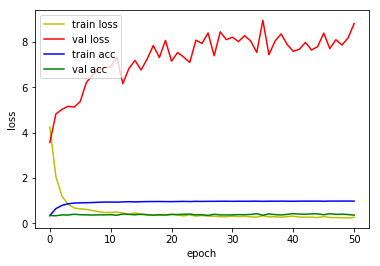

4815/4815 [==============================] - 4s 786us/sample - loss: 3.7863 - acc: 0.3173
Loss: 3.7862682504445964 Accuracy: 0.31734166

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2915 - acc: 0.4291
Epoch 00001: val_loss improved from inf to 2.05941, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_2_checkpoint/001-2.0594.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.2915 - acc: 0.4291 - val_loss: 2.0594 - val_acc: 0.4088
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9763 - acc: 0.7246
Epoch 00002: val_loss improved from 2.05941 to 2.02534, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_2_checkpoint/002-2.0253.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.9767 - acc: 0.7245 - val_loss: 2.0253 - val_acc: 0.5029
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4870 - ac

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9867
Epoch 00030: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0678 - acc: 0.9867 - val_loss: 4.0537 - val_acc: 0.5006
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9836
Epoch 00031: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0768 - acc: 0.9836 - val_loss: 3.8812 - val_acc: 0.5297
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9901
Epoch 00032: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0562 - acc: 0.9901 - val_loss: 3.7376 - val_acc: 0.5334
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9902
Epoch 00033: val_loss did not improve from 2.02534
36805/36805 [===========

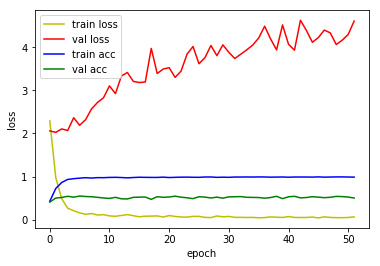

4815/4815 [==============================] - 4s 872us/sample - loss: 2.1049 - acc: 0.4687
Loss: 2.104940150633284 Accuracy: 0.4687435

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8262 - acc: 0.4738
Epoch 00001: val_loss improved from inf to 1.55467, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_2_checkpoint/001-1.5547.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.8263 - acc: 0.4738 - val_loss: 1.5547 - val_acc: 0.5246
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0889 - acc: 0.6755
Epoch 00002: val_loss improved from 1.55467 to 1.27578, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_2_checkpoint/002-1.2758.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.0891 - acc: 0.6755 - val_loss: 1.2758 - val_acc: 0.6366
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7648 - acc:

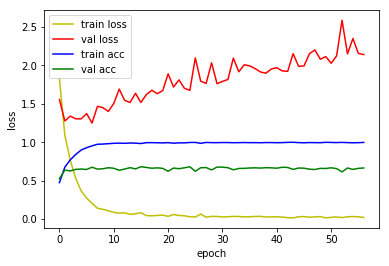

4815/4815 [==============================] - 5s 935us/sample - loss: 1.3484 - acc: 0.6471
Loss: 1.3483520427596902 Accuracy: 0.6471443

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6775 - acc: 0.5020
Epoch 00001: val_loss improved from inf to 1.40934, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_2_checkpoint/001-1.4093.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 1.6777 - acc: 0.5019 - val_loss: 1.4093 - val_acc: 0.5644
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0400 - acc: 0.6891
Epoch 00002: val_loss improved from 1.40934 to 1.02985, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_2_checkpoint/002-1.0299.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.0400 - acc: 0.6891 - val_loss: 1.0299 - val_acc: 0.7044
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7910 - acc

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9895
Epoch 00029: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0474 - acc: 0.9895 - val_loss: 1.2069 - val_acc: 0.7547
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9932
Epoch 00030: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0363 - acc: 0.9932 - val_loss: 1.3308 - val_acc: 0.7352
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9925
Epoch 00031: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0392 - acc: 0.9925 - val_loss: 1.3818 - val_acc: 0.7342
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9950
Epoch 00032: val_loss did not improve from 0.95749
36805/36805 [===========

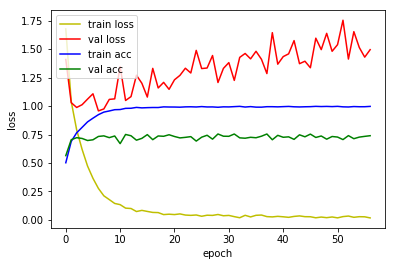

4815/4815 [==============================] - 5s 993us/sample - loss: 1.0188 - acc: 0.7082
Loss: 1.0188418635698122 Accuracy: 0.70820355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6810 - acc: 0.4889
Epoch 00001: val_loss improved from inf to 1.61349, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_2_checkpoint/001-1.6135.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.6810 - acc: 0.4889 - val_loss: 1.6135 - val_acc: 0.4635
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0376 - acc: 0.6915
Epoch 00002: val_loss improved from 1.61349 to 0.95815, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_2_checkpoint/002-0.9582.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.0377 - acc: 0.6915 - val_loss: 0.9582 - val_acc: 0.7247
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8318 - a

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9865
Epoch 00028: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0632 - acc: 0.9865 - val_loss: 0.6699 - val_acc: 0.8367
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9906
Epoch 00029: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0523 - acc: 0.9905 - val_loss: 0.6209 - val_acc: 0.8435
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9899
Epoch 00030: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0532 - acc: 0.9899 - val_loss: 0.6150 - val_acc: 0.8484
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.55473
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9976
Epoch 00058: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0184 - acc: 0.9976 - val_loss: 0.6171 - val_acc: 0.8651
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0235 - acc: 0.9957 - val_loss: 0.6923 - val_acc: 0.8570
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9931
Epoch 00060: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0296 - acc: 0.9931 - val_loss: 0.6216 - val_acc: 0.8675
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9982
Epoch 00061: val_loss did not improve from 0.55473
36805/36805 [===========

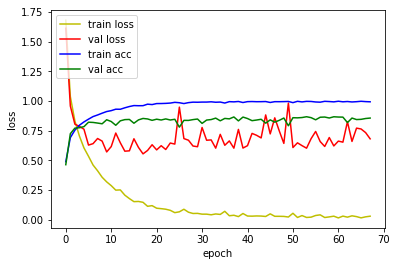

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6072 - acc: 0.8326
Loss: 0.6071557677175892 Accuracy: 0.83260643

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7100 - acc: 0.4775
Epoch 00001: val_loss improved from inf to 1.41256, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_2_checkpoint/001-1.4126.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.7099 - acc: 0.4776 - val_loss: 1.4126 - val_acc: 0.5588
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9754 - acc: 0.7123
Epoch 00002: val_loss improved from 1.41256 to 0.78696, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_2_checkpoint/002-0.7870.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.9755 - acc: 0.7123 - val_loss: 0.7870 - val_acc: 0.7743
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7270 - acc

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9841
Epoch 00026: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0659 - acc: 0.9841 - val_loss: 0.3049 - val_acc: 0.9199
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9914
Epoch 00027: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0443 - acc: 0.9914 - val_loss: 0.3499 - val_acc: 0.9071
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9850
Epoch 00028: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0625 - acc: 0.9849 - val_loss: 0.3004 - val_acc: 0.9238
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9904
Epoch 00029: val_loss improved from 0.28954 to 0.25623, saving model to mod

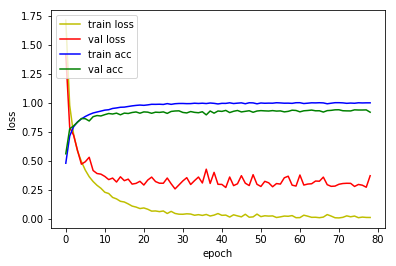

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3194 - acc: 0.9109
Loss: 0.31939273372617466 Accuracy: 0.91090345

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5113 - acc: 0.5452
Epoch 00001: val_loss improved from inf to 1.18224, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_2_checkpoint/001-1.1822.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 1.5113 - acc: 0.5453 - val_loss: 1.1822 - val_acc: 0.6443
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7029 - acc: 0.7993
Epoch 00002: val_loss improved from 1.18224 to 0.56464, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_2_checkpoint/002-0.5646.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.7031 - acc: 0.7993 - val_loss: 0.5646 - val_acc: 0.8437
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4810 - ac

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9933
Epoch 00027: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0310 - acc: 0.9933 - val_loss: 0.3363 - val_acc: 0.9180
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9935
Epoch 00028: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0294 - acc: 0.9935 - val_loss: 0.2105 - val_acc: 0.9460
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9967
Epoch 00029: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0189 - acc: 0.9966 - val_loss: 0.2209 - val_acc: 0.9397
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9907
Epoch 00030: val_loss did not improve from 0.16455
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9983
Epoch 00057: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0080 - acc: 0.9983 - val_loss: 0.1774 - val_acc: 0.9564
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9994
Epoch 00058: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0041 - acc: 0.9994 - val_loss: 0.1755 - val_acc: 0.9569
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9970
Epoch 00059: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0134 - acc: 0.9970 - val_loss: 0.1806 - val_acc: 0.9562
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9982
Epoch 00060: val_loss did not improve from 0.16455
36805/36805 [===========

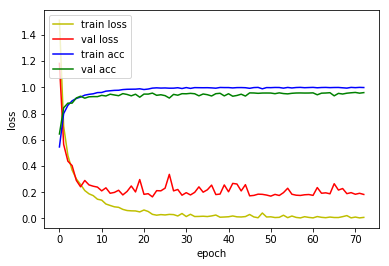

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2045 - acc: 0.9364
Loss: 0.20451734931298135 Accuracy: 0.9364486

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0841 - acc: 0.6678
Epoch 00001: val_loss improved from inf to 0.72409, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_2_checkpoint/001-0.7241.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.0840 - acc: 0.6678 - val_loss: 0.7241 - val_acc: 0.7934
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4252 - acc: 0.8721
Epoch 00002: val_loss improved from 0.72409 to 0.32088, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_2_checkpoint/002-0.3209.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.4252 - acc: 0.8721 - val_loss: 0.3209 - val_acc: 0.9026
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2861 - acc

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9979
Epoch 00028: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0101 - acc: 0.9979 - val_loss: 0.1711 - val_acc: 0.9557
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9926
Epoch 00029: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0267 - acc: 0.9926 - val_loss: 0.1639 - val_acc: 0.9553
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9992
Epoch 00030: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0065 - acc: 0.9992 - val_loss: 0.1433 - val_acc: 0.9632
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9988
Epoch 00031: val_loss did not improve from 0.14272
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0036 - acc: 0.9993 - val_loss: 0.1606 - val_acc: 0.9632
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9990
Epoch 00059: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0039 - acc: 0.9990 - val_loss: 0.2424 - val_acc: 0.9448
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9965
Epoch 00060: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0115 - acc: 0.9964 - val_loss: 0.2298 - val_acc: 0.9509
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9946
Epoch 00061: val_loss did not improve from 0.14272
36805/36805 [===========

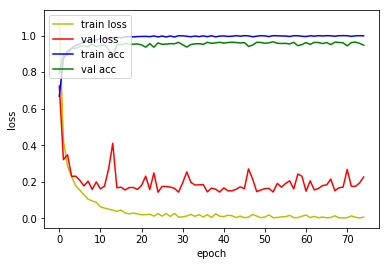

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2054 - acc: 0.9435
Loss: 0.2054227645647241 Accuracy: 0.9435099



In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN_2'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN_2'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
_______________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3484 - acc: 0.6471
Loss: 1.3483520427596902 Accuracy: 0.6471443

1D_CNN_5_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 16000,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3194 - acc: 0.9109
Loss: 0.31939273372617466 Accuracy: 0.91090345

1D_CNN_8_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 1600

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2054 - acc: 0.9435
Loss: 0.2054227645647241 Accuracy: 0.9435099


Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.7719 - acc: 0.2139
Epoch 00001: val_loss improved from inf to 12.57896, saving model to model/checkpoint/1D_CNN_custom_BN_2_1_conv_checkpoint/001-12.5790.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 11.7713 - acc: 0.2139 - val_loss: 12.5790 - val_acc: 0.1691
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.6552 - acc: 0.3026
Epoch 00002: val_loss improved from 12.57896 to 11.23500, saving model to model/checkpoint/1D_CNN_custom_BN_2_1_conv_checkpoint/002-11.2350.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 10.6552 - acc: 0.3026 - val_loss: 11.2350 - val_acc: 0.2648
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.9582 - acc: 0.3

36800/36805 [============================>.] - ETA: 0s - loss: 6.1611 - acc: 0.6059
Epoch 00026: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.1611 - acc: 0.6059 - val_loss: 10.4381 - val_acc: 0.3324
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.1218 - acc: 0.6095
Epoch 00027: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.1215 - acc: 0.6096 - val_loss: 10.3843 - val_acc: 0.3322
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.0685 - acc: 0.6121
Epoch 00028: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.0682 - acc: 0.6121 - val_loss: 10.9309 - val_acc: 0.3031
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.0686 - acc: 0.6123
Epoch 00029: val_loss did not improve from 10.16129
36805/36805 [=================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.9058 - acc: 0.6890
Epoch 00056: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.9064 - acc: 0.6890 - val_loss: 10.9439 - val_acc: 0.3038
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8683 - acc: 0.6913
Epoch 00057: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.8694 - acc: 0.6912 - val_loss: 10.2737 - val_acc: 0.3417
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8546 - acc: 0.6921
Epoch 00058: val_loss did not improve from 10.16129
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.8548 - acc: 0.6921 - val_loss: 10.2655 - val_acc: 0.3413
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.7863 - acc: 0.6973
Epoch 00059: val_loss did not improve from 10.16129
36805/36805 [====

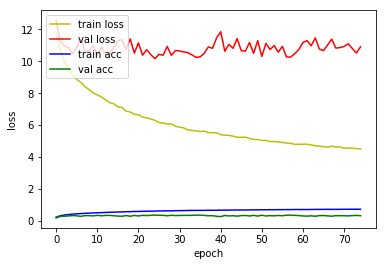

4815/4815 [==============================] - 3s 556us/sample - loss: 10.5517 - acc: 0.3221
Loss: 10.551671287005812 Accuracy: 0.32211837

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4247 - acc: 0.3315
Epoch 00001: val_loss improved from inf to 3.98134, saving model to model/checkpoint/1D_CNN_custom_BN_2_2_conv_checkpoint/001-3.9813.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 4.4247 - acc: 0.3315 - val_loss: 3.9813 - val_acc: 0.3110
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2503 - acc: 0.6245
Epoch 00002: val_loss did not improve from 3.98134
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.2510 - acc: 0.6245 - val_loss: 6.4390 - val_acc: 0.2916
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3551 - acc: 0.7657
Epoch 00003: val_loss did not improve from 3.98134
36805/36805 [================

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3643 - acc: 0.9623
Epoch 00030: val_loss did not improve from 3.98134
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.3642 - acc: 0.9623 - val_loss: 7.4873 - val_acc: 0.4025
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3075 - acc: 0.9699
Epoch 00031: val_loss did not improve from 3.98134
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.3075 - acc: 0.9699 - val_loss: 8.0003 - val_acc: 0.3839
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3189 - acc: 0.9693
Epoch 00032: val_loss did not improve from 3.98134
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.3190 - acc: 0.9693 - val_loss: 7.6662 - val_acc: 0.4009
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.9667
Epoch 00033: val_loss did not improve from 3.98134
36805/36805 [===========

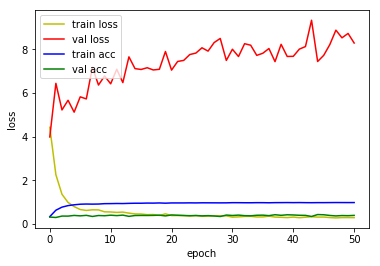

4815/4815 [==============================] - 3s 722us/sample - loss: 4.1062 - acc: 0.2987
Loss: 4.1062096585861 Accuracy: 0.29865006

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3246 - acc: 0.4257
Epoch 00001: val_loss improved from inf to 2.18126, saving model to model/checkpoint/1D_CNN_custom_BN_2_3_conv_checkpoint/001-2.1813.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.3247 - acc: 0.4257 - val_loss: 2.1813 - val_acc: 0.3969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0400 - acc: 0.7112
Epoch 00002: val_loss improved from 2.18126 to 1.93862, saving model to model/checkpoint/1D_CNN_custom_BN_2_3_conv_checkpoint/002-1.9386.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.0403 - acc: 0.7112 - val_loss: 1.9386 - val_acc: 0.5250
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5116 - acc: 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9867
Epoch 00030: val_loss did not improve from 1.93862
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0646 - acc: 0.9867 - val_loss: 3.8466 - val_acc: 0.5225
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9893
Epoch 00031: val_loss did not improve from 1.93862
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0551 - acc: 0.9893 - val_loss: 4.3648 - val_acc: 0.4775
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9818
Epoch 00032: val_loss did not improve from 1.93862
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0918 - acc: 0.9818 - val_loss: 4.4986 - val_acc: 0.5006
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9885
Epoch 00033: val_loss did not improve from 1.93862
36805/36805 [===========

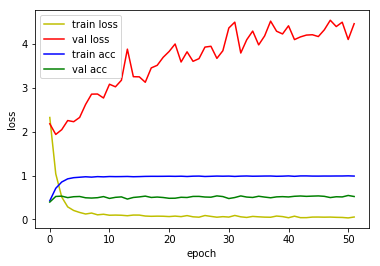

4815/4815 [==============================] - 4s 811us/sample - loss: 2.0156 - acc: 0.4870
Loss: 2.0155845355888515 Accuracy: 0.48701972

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8403 - acc: 0.4719
Epoch 00001: val_loss improved from inf to 1.65539, saving model to model/checkpoint/1D_CNN_custom_BN_2_4_conv_checkpoint/001-1.6554.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.8403 - acc: 0.4719 - val_loss: 1.6554 - val_acc: 0.4726
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0896 - acc: 0.6790
Epoch 00002: val_loss improved from 1.65539 to 1.27591, saving model to model/checkpoint/1D_CNN_custom_BN_2_4_conv_checkpoint/002-1.2759.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.0896 - acc: 0.6790 - val_loss: 1.2759 - val_acc: 0.6471
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7522 - ac

36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9950
Epoch 00029: val_loss did not improve from 1.27330
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0317 - acc: 0.9950 - val_loss: 1.9144 - val_acc: 0.6548
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9942
Epoch 00030: val_loss did not improve from 1.27330
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0331 - acc: 0.9942 - val_loss: 1.8625 - val_acc: 0.6606
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9965
Epoch 00031: val_loss did not improve from 1.27330
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0264 - acc: 0.9964 - val_loss: 1.9927 - val_acc: 0.6401
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9923
Epoch 00032: val_loss did not improve from 1.27330
36805/36805 [========================

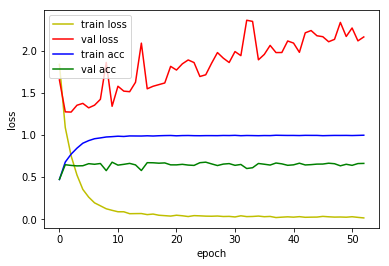

4815/4815 [==============================] - 4s 873us/sample - loss: 1.3403 - acc: 0.6160
Loss: 1.340295346404657 Accuracy: 0.6159917

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6920 - acc: 0.4971
Epoch 00001: val_loss improved from inf to 1.39239, saving model to model/checkpoint/1D_CNN_custom_BN_2_5_conv_checkpoint/001-1.3924.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 1.6918 - acc: 0.4971 - val_loss: 1.3924 - val_acc: 0.5763
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0587 - acc: 0.6837
Epoch 00002: val_loss improved from 1.39239 to 1.11347, saving model to model/checkpoint/1D_CNN_custom_BN_2_5_conv_checkpoint/002-1.1135.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.0588 - acc: 0.6837 - val_loss: 1.1135 - val_acc: 0.6716
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8155 - acc:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9957
Epoch 00029: val_loss did not improve from 0.98199
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0281 - acc: 0.9956 - val_loss: 1.4959 - val_acc: 0.7021
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9930
Epoch 00030: val_loss did not improve from 0.98199
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0389 - acc: 0.9929 - val_loss: 1.6597 - val_acc: 0.6890
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9917
Epoch 00031: val_loss did not improve from 0.98199
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0403 - acc: 0.9917 - val_loss: 1.4139 - val_acc: 0.7226
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9937
Epoch 00032: val_loss did not improve from 0.98199
36805/36805 [===========


1D_CNN_custom_BN_2_5_conv Model


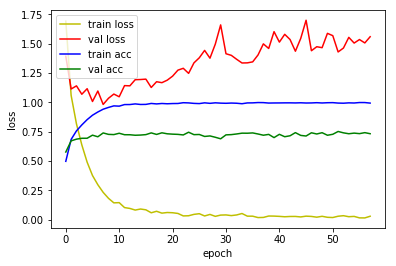

4815/4815 [==============================] - 4s 907us/sample - loss: 1.0246 - acc: 0.7134
Loss: 1.0246255337387353 Accuracy: 0.71339566

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7004 - acc: 0.4772
Epoch 00001: val_loss improved from inf to 1.48658, saving model to model/checkpoint/1D_CNN_custom_BN_2_6_conv_checkpoint/001-1.4866.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 1.7004 - acc: 0.4772 - val_loss: 1.4866 - val_acc: 0.5220
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0422 - acc: 0.6865
Epoch 00002: val_loss improved from 1.48658 to 0.99574, saving model to model/checkpoint/1D_CNN_custom_BN_2_6_conv_checkpoint/002-0.9957.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.0423 - acc: 0.6865 - val_loss: 0.9957 - val_acc: 0.6995
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8401 - ac

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9901
Epoch 00028: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0524 - acc: 0.9900 - val_loss: 0.7290 - val_acc: 0.8213
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9807
Epoch 00029: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0854 - acc: 0.9807 - val_loss: 0.6420 - val_acc: 0.8400
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9931
Epoch 00030: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0433 - acc: 0.9930 - val_loss: 0.6806 - val_acc: 0.8451
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.54146
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0264 - acc: 0.9949 - val_loss: 0.6593 - val_acc: 0.8523
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9972
Epoch 00059: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0175 - acc: 0.9972 - val_loss: 0.7025 - val_acc: 0.8514
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9915
Epoch 00060: val_loss did not improve from 0.54146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0374 - acc: 0.9915 - val_loss: 0.6543 - val_acc: 0.8654
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9985
Epoch 00061: val_loss did not improve from 0.54146
36805/36805 [===========

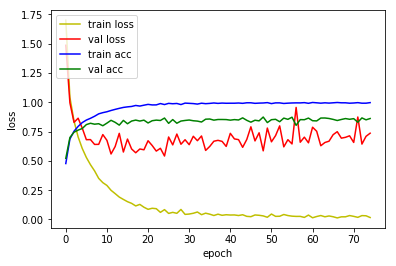

4815/4815 [==============================] - 5s 953us/sample - loss: 0.6375 - acc: 0.8314
Loss: 0.6375187798700105 Accuracy: 0.83136034

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7287 - acc: 0.4675
Epoch 00001: val_loss improved from inf to 1.38389, saving model to model/checkpoint/1D_CNN_custom_BN_2_7_conv_checkpoint/001-1.3839.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.7286 - acc: 0.4675 - val_loss: 1.3839 - val_acc: 0.5744
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9928 - acc: 0.7057
Epoch 00002: val_loss improved from 1.38389 to 0.83451, saving model to model/checkpoint/1D_CNN_custom_BN_2_7_conv_checkpoint/002-0.8345.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.9927 - acc: 0.7057 - val_loss: 0.8345 - val_acc: 0.7533
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7345 - a

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9914
Epoch 00026: val_loss did not improve from 0.29746
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0480 - acc: 0.9914 - val_loss: 0.3680 - val_acc: 0.9087
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9787
Epoch 00027: val_loss did not improve from 0.29746
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0843 - acc: 0.9787 - val_loss: 0.3330 - val_acc: 0.9131
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9911
Epoch 00028: val_loss did not improve from 0.29746
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0446 - acc: 0.9911 - val_loss: 0.3100 - val_acc: 0.9217
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9920
Epoch 00029: val_loss did not improve from 0.29746
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9939
Epoch 00055: val_loss did not improve from 0.27760
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0257 - acc: 0.9939 - val_loss: 0.3057 - val_acc: 0.9324
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9966
Epoch 00056: val_loss did not improve from 0.27760
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0167 - acc: 0.9966 - val_loss: 0.2890 - val_acc: 0.9341
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.27760
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0190 - acc: 0.9961 - val_loss: 0.3159 - val_acc: 0.9311
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9945
Epoch 00058: val_loss did not improve from 0.27760
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9995
Epoch 00085: val_loss did not improve from 0.27442
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0066 - acc: 0.9994 - val_loss: 0.2978 - val_acc: 0.9327
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9939
Epoch 00086: val_loss did not improve from 0.27442
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0238 - acc: 0.9939 - val_loss: 0.3025 - val_acc: 0.9280
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.27442
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0076 - acc: 0.9991 - val_loss: 0.2772 - val_acc: 0.9380
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9995
Epoch 00088: val_loss did not improve from 0.27442
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9956
Epoch 00114: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0171 - acc: 0.9956 - val_loss: 0.3577 - val_acc: 0.9238
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9944
Epoch 00115: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0204 - acc: 0.9944 - val_loss: 0.2949 - val_acc: 0.9376
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9996
Epoch 00116: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0045 - acc: 0.9996 - val_loss: 0.3267 - val_acc: 0.9320
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9990
Epoch 00117: val_loss did not improve from 0.26641
36805/36805 [=====================

Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9995
Epoch 00144: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0042 - acc: 0.9995 - val_loss: 0.3179 - val_acc: 0.9364
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9996
Epoch 00145: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0044 - acc: 0.9996 - val_loss: 0.3143 - val_acc: 0.9378
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9995
Epoch 00146: val_loss did not improve from 0.26641
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0040 - acc: 0.9995 - val_loss: 0.3287 - val_acc: 0.9315
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9989
Epoch 00147: val_loss did not improve from 0.26641
36805/36805 [=======

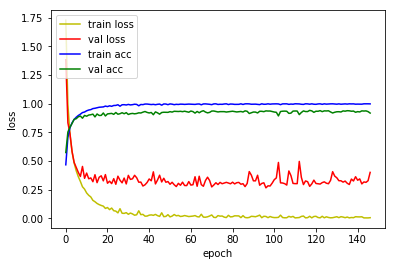

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3183 - acc: 0.9192
Loss: 0.3183324581172669 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5725 - acc: 0.5220
Epoch 00001: val_loss improved from inf to 1.21897, saving model to model/checkpoint/1D_CNN_custom_BN_2_8_conv_checkpoint/001-1.2190.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.5726 - acc: 0.5220 - val_loss: 1.2190 - val_acc: 0.6217
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7177 - acc: 0.7943
Epoch 00002: val_loss improved from 1.21897 to 0.56147, saving model to model/checkpoint/1D_CNN_custom_BN_2_8_conv_checkpoint/002-0.5615.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.7177 - acc: 0.7943 - val_loss: 0.5615 - val_acc: 0.8411
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4860 - acc:

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9924
Epoch 00026: val_loss did not improve from 0.17282
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0338 - acc: 0.9924 - val_loss: 0.1851 - val_acc: 0.9495
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9948
Epoch 00027: val_loss did not improve from 0.17282
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0256 - acc: 0.9948 - val_loss: 0.1991 - val_acc: 0.9474
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9969
Epoch 00028: val_loss did not improve from 0.17282
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0193 - acc: 0.9969 - val_loss: 0.1996 - val_acc: 0.9439
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9960
Epoch 00029: val_loss did not improve from 0.17282
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9995
Epoch 00055: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0045 - acc: 0.9995 - val_loss: 0.2188 - val_acc: 0.9469
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9917
Epoch 00056: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0304 - acc: 0.9917 - val_loss: 0.1845 - val_acc: 0.9520
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9946
Epoch 00057: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0200 - acc: 0.9945 - val_loss: 0.1706 - val_acc: 0.9548
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9946
Epoch 00058: val_loss did not improve from 0.15448
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9951
Epoch 00085: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0165 - acc: 0.9951 - val_loss: 0.1600 - val_acc: 0.9585
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9992
Epoch 00086: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0043 - acc: 0.9992 - val_loss: 0.1980 - val_acc: 0.9539
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9995
Epoch 00087: val_loss did not improve from 0.15448
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0037 - acc: 0.9995 - val_loss: 0.1556 - val_acc: 0.9630
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9996
Epoch 00088: val_loss did not improve from 0.15448
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9975
Epoch 00114: val_loss did not improve from 0.15407
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0084 - acc: 0.9975 - val_loss: 0.2436 - val_acc: 0.9490
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9968
Epoch 00115: val_loss did not improve from 0.15407
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0118 - acc: 0.9968 - val_loss: 0.1784 - val_acc: 0.9543
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9995
Epoch 00116: val_loss did not improve from 0.15407
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0029 - acc: 0.9995 - val_loss: 0.1591 - val_acc: 0.9616
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9987
Epoch 00117: val_loss did not improve from 0.15407
36805/36805 [=====================

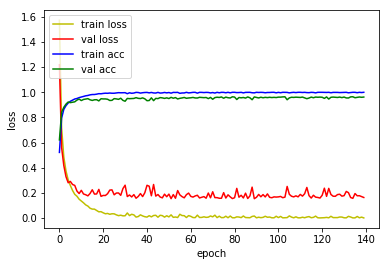

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2246 - acc: 0.9458
Loss: 0.2246089458840813 Accuracy: 0.9457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1173 - acc: 0.6551
Epoch 00001: val_loss improved from inf to 0.77742, saving model to model/checkpoint/1D_CNN_custom_BN_2_9_conv_checkpoint/001-0.7774.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 1.1173 - acc: 0.6551 - val_loss: 0.7774 - val_acc: 0.7785
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4391 - acc: 0.8668
Epoch 00002: val_loss improved from 0.77742 to 0.32458, saving model to model/checkpoint/1D_CNN_custom_BN_2_9_conv_checkpoint/002-0.3246.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.4391 - acc: 0.8668 - val_loss: 0.3246 - val_acc: 0.9017
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2931 - acc:

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9900
Epoch 00028: val_loss did not improve from 0.15003
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0356 - acc: 0.9900 - val_loss: 0.1773 - val_acc: 0.9562
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9980
Epoch 00029: val_loss did not improve from 0.15003
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0098 - acc: 0.9979 - val_loss: 0.1690 - val_acc: 0.9576
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9930
Epoch 00030: val_loss did not improve from 0.15003
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0266 - acc: 0.9930 - val_loss: 0.2310 - val_acc: 0.9411
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9934
Epoch 00031: val_loss did not improve from 0.15003
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9968
Epoch 00058: val_loss did not improve from 0.15003
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0105 - acc: 0.9968 - val_loss: 0.2076 - val_acc: 0.9529
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9995
Epoch 00059: val_loss did not improve from 0.15003
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0032 - acc: 0.9995 - val_loss: 0.1678 - val_acc: 0.9632
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9996
Epoch 00060: val_loss did not improve from 0.15003
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1786 - val_acc: 0.9588
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9948
Epoch 00061: val_loss did not improve from 0.15003
36805/36805 [===========

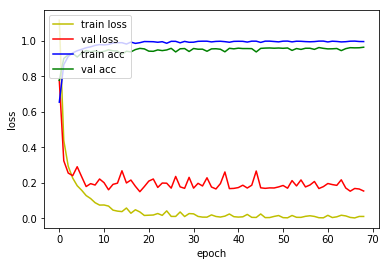

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1964 - acc: 0.9408
Loss: 0.196356212396488 Accuracy: 0.94080997



In [9]:
for i in range(1, 10):
    base = '1D_CNN_custom_BN_2'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_BN_2_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
_______________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3403 - acc: 0.6160
Loss: 1.340295346404657 Accuracy: 0.6159917

1D_CNN_custom_BN_2_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_14 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3183 - acc: 0.9192
Loss: 0.3183324581172669 Accuracy: 0.9192108

1D_CNN_custom_BN_2_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_35 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1964 - acc: 0.9408
Loss: 0.196356212396488 Accuracy: 0.94080997


In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_BN_2_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
_______________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 2.3427 - acc: 0.6291
Loss: 2.3426765838020933 Accuracy: 0.6290758

1D_CNN_custom_BN_2_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_14 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4342 - acc: 0.9061
Loss: 0.43415780395486026 Accuracy: 0.9061267

1D_CNN_custom_BN_2_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_35 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2075 - acc: 0.9464
Loss: 0.2074711796256055 Accuracy: 0.94641745
